In [1]:
import numpy as np
from pathlib import Path
import h5py
from tqdm import tqdm
from itertools import product
import multiprocessing as mp

In [2]:
import matplotlib.pyplot as plt

In [3]:
from robust_motifs.data import (save_count_graph_from_matrix, matrix_shuffle,
                                import_connectivity_matrix, adjust_bidirectional_edges,
                               load_sparse_matrix_from_pkl)
from robust_motifs.custom_mp import prepare_shared_memory
from robust_motifs.counting import get_bisimplices

In [4]:
original_matrix = import_connectivity_matrix(dataframe = False, type = 'csr')

pathway_shuffled_matrix = import_connectivity_matrix(dataframe= False, type='csr', pathway_shuffle=True)

shuffled_matrix = matrix_shuffle(original_matrix)

100%|██████████| 55/55 [00:36<00:00,  1.53it/s]


In [5]:
original_matrix.multiply(original_matrix.T)

pathway_shuffled_matrix.multiply(pathway_shuffled_matrix.T)

shuffled_matrix.multiply(shuffled_matrix.T)

<31346x31346 sparse matrix of type '<class 'numpy.bool_'>'
	with 59482 stored elements in Compressed Sparse Row format>

In [6]:
bid_adjusted_matrix = adjust_bidirectional_edges(shuffled_matrix, int(182932/2))

Adding bidirectional edges...: 100%|██████████| 61725/61725 [00:00<00:00, 157731.13it/s]


In [7]:
bid_adjusted_matrix.multiply(bid_adjusted_matrix.T)

<31346x31346 sparse matrix of type '<class 'numpy.bool_'>'
	with 182932 stored elements in Compressed Sparse Row format>

### Processing

### Column

In [8]:
save_path = Path("data/models/column/column.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, original_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 3479730.39it/s]
7648079it [00:11, 692635.13it/s]


In [9]:
pool = mp.Pool()

In [10]:
overall_results = {}
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_bisimplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, set()).union(set(elem))
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = set()
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        result_dictionary[dimension] = len(result_dictionary[dimension])
        
        overall_results[dimension] = overall_results.get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 3848, 2: 437, 3: 76, 4: 13, 5: 5, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 3779, 2: 494, 3: 80, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 3926, 2: 486, 3: 80, 4: 17, 5: 3, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 3963, 2: 457, 3: 94, 4: 27, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 3935, 2: 495, 3: 65, 4: 21, 5: 2, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 3931, 2: 415, 3: 90, 4: 17, 5: 1, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 3987, 2: 479, 3: 76, 4: 13, 5: 4, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 3888, 2: 498, 3: 89, 4: 16, 5: 2, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 3885, 2: 479, 3: 75, 4: 21, 5: 1, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


100%|██████████| 6/6 [02:05<00:00, 20.88s/it]

Extended simplices for 10000 simplices per dimension
{1: 3973, 2: 501, 3: 75, 4: 10, 5: 1, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


<BarContainer object of 6 artists>

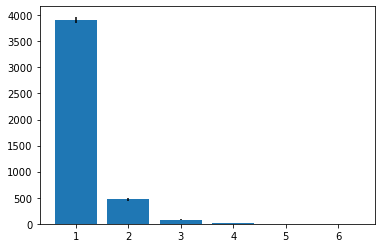

In [11]:
a = []
b = []
for elem in overall_results.values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)

### Pathway shuffled

In [12]:
save_path = Path("data/models/pshuffled/pshuffled.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, pathway_shuffled_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 3203261.21it/s]
7648079it [00:10, 699196.47it/s]


In [13]:
pool = mp.Pool()

In [14]:
overall_results = {}
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_bisimplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, set()).union(set(elem))
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = set()
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        result_dictionary[dimension] = len(result_dictionary[dimension])
        
        overall_results[dimension] = overall_results.get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 496, 2: 10, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 445, 2: 15, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 453, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 440, 2: 12, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 431, 2: 13, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 431, 2: 9, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 419, 2: 9, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 475, 2: 9, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 455, 2: 9, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


100%|██████████| 6/6 [00:59<00:00,  9.88s/it]

Extended simplices for 10000 simplices per dimension
{1: 442, 2: 9, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24795659, 3: 1421317, 4: 1771, 5: 0, 6: 0}


<BarContainer object of 6 artists>

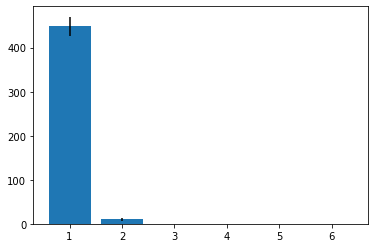

In [15]:
a = []
b = []
for elem in overall_results.values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)

### ER

In [16]:
save_path = Path("data/models/shuffled/shuffled.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, shuffled_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 3164937.13it/s]
7586354it [00:11, 674021.28it/s]


In [17]:
pool = mp.Pool()

In [18]:
overall_results = {}
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_bisimplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, set()).union(set(elem))
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = set()
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        result_dictionary[dimension] = len(result_dictionary[dimension])
        
        overall_results[dimension] = overall_results.get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 225, 2: 83, 3: 69, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 205, 2: 69, 3: 76, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 232, 2: 81, 3: 79, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 243, 2: 90, 3: 77, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 229, 2: 94, 3: 86, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 251, 2: 79, 3: 84, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 253, 2: 93, 3: 66, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 232, 2: 76, 3: 79, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 223, 2: 93, 3: 82, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


100%|██████████| 6/6 [00:54<00:00,  9.17s/it]

Extended simplices for 10000 simplices per dimension
{1: 244, 2: 94, 3: 68, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7586354, 2: 14238777, 3: 319404, 4: 1703, 5: 0, 6: 0}


<BarContainer object of 6 artists>

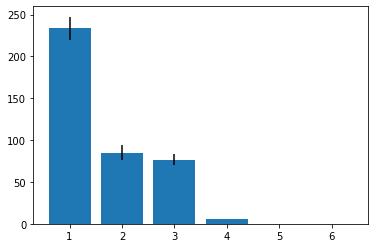

In [19]:
a = []
b = []
for elem in overall_results.values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)

### ER bid adjusted

In [20]:
save_path = Path("data/models/adjusted/adjusted.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, bid_adjusted_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 3200376.16it/s]
7648079it [00:11, 686490.25it/s]


In [21]:
pool = mp.Pool()

In [22]:
overall_results = {}
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_bisimplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, set()).union(set(elem))
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = set()
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        result_dictionary[dimension] = len(result_dictionary[dimension])
        
        overall_results[dimension] = overall_results.get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 513, 2: 88, 3: 78, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 485, 2: 70, 3: 87, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 512, 2: 90, 3: 85, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 515, 2: 71, 3: 84, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 483, 2: 80, 3: 87, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 502, 2: 79, 3: 87, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 544, 2: 91, 3: 76, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 558, 2: 97, 3: 83, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 523, 2: 94, 3: 76, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


100%|██████████| 6/6 [01:02<00:00, 10.49s/it]

Extended simplices for 10000 simplices per dimension
{1: 515, 2: 97, 3: 104, 4: 6, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14589381, 3: 334329, 4: 1816, 5: 0, 6: 0}


<BarContainer object of 6 artists>

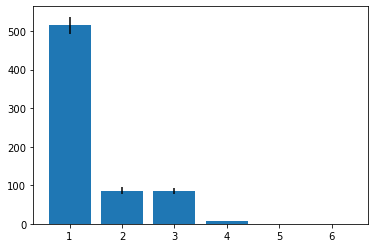

In [23]:
a = []
b = []
for elem in overall_results.values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)